In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
sys.path.append(os.path.abspath("../.."))  # Adds the project root to sys.path
import numpy as np 
import math
import tensorflow as tf

from recommenders.datasets.linear_regression import *

In [2]:
save_rating_values()

In [3]:
product_features, Y, R, num_features, num_products = get_data()

Y (7, 3) R (7, 3)
X (7, 10)
num_features 10
num_products 7
num_users 3


In [ ]:
# my_ratings = np.zeros(num_products)

# my_ratings[0] = 5 # Bosch, Burgija
# my_ratings[1] = 1 # Bosch, Testera
# my_ratings[2] = 1 # Bosch, Testera

# # Add new user ratings to Y 
# Y = np.c_[my_ratings, Y]

# # Add new user indicator matrix to R
# R = np.c_[(my_ratings != 0).astype(int), R]

# Normalize the Dataset


In [8]:
test_recency_bonus(100, 20)

Day 1: 1.9025
Day 2: 1.8097
Day 3: 1.7214
Day 4: 1.6375
Day 5: 1.5576
Day 6: 1.4816
Day 7: 1.4094
Day 8: 1.3406
Day 9: 1.2753
Day 10: 1.2131
Day 11: 1.1539
Day 12: 1.0976
Day 13: 1.0441
Day 14: 0.9932
Day 15: 0.9447
Day 16: 0.8987
Day 17: 0.8548
Day 18: 0.8131
Day 19: 0.7735
Day 20: 0.7358
Day 21: 0.6999
Day 22: 0.6657
Day 23: 0.6333
Day 24: 0.6024
Day 25: 0.5730
Day 26: 0.5451
Day 27: 0.5185
Day 28: 0.4932
Day 29: 0.4691
Day 30: 0.4463
Day 31: 0.4245
Day 32: 0.4038
Day 33: 0.3841
Day 34: 0.3654
Day 35: 0.3475
Day 36: 0.3306
Day 37: 0.3145
Day 38: 0.2991
Day 39: 0.2845
Day 40: 0.2707
Day 41: 0.2575
Day 42: 0.2449
Day 43: 0.2330
Day 44: 0.2216
Day 45: 0.2108
Day 46: 0.2005
Day 47: 0.1907
Day 48: 0.1814
Day 49: 0.1726
Day 50: 0.1642
Day 51: 0.1562
Day 52: 0.1485
Day 53: 0.1413
Day 54: 0.1344
Day 55: 0.1279
Day 56: 0.1216
Day 57: 0.1157
Day 58: 0.1100
Day 59: 0.1047
Day 60: 0.0996
Day 61: 0.0947
Day 62: 0.0901
Day 63: 0.0857
Day 64: 0.0815
Day 65: 0.0775
Day 66: 0.0738
Day 67: 0.0702
Day 

In [4]:
num_users = Y.shape[1] # FT: It's mandatory because we could add one more user to the matrix

X, W, b = initialize_tf_variables(product_features, num_features, num_users)

Training loss at iteration 0: 41.474
Training loss at iteration 20: 4.509
Training loss at iteration 40: 3.434
Training loss at iteration 60: 3.281
Training loss at iteration 80: 3.255
Training loss at iteration 100: 3.251
Training loss at iteration 120: 3.251
Training loss at iteration 140: 3.251
Training loss at iteration 160: 3.251
Training loss at iteration 180: 3.251


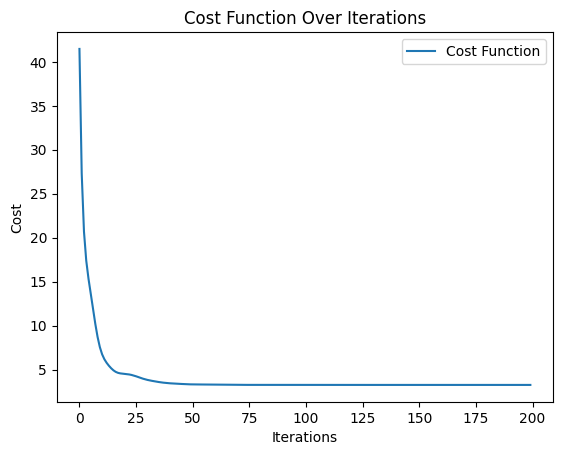

In [5]:
Ynorm, Ymean = normalize_ratings(Y, R)
calculate_parameters(X, W, b, Ynorm, R, iterations=200, lambda_=1, learning_rate=0.1)

In [6]:
product_names = load_csv_list('../../recommenders/datasets/pa/product_names.csv')

# Make a prediction using trained weights and biases
predictions_normalized = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()

#restore the mean
predictions = predictions_normalized + Ymean

rmse(Y, predictions, R)

my_predictions = predictions[:,0]

# sort predictions
ix = tf.argsort(my_predictions, direction='DESCENDING')

# for i in range(len(my_ratings)):
#     # print(f'{my_predictions[i]:0.2f}')
#     if my_ratings[i] > 0:
#         print(f'Original {my_ratings[i]}, Predicted {my_predictions[i]:0.2f} for {product_names[i]}')

RMSE score: 0.3075149027551882
